<a href="https://colab.research.google.com/github/ashishpatel26/Shapelet-time-Series-Classification/blob/main/Early_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tslearn

     |████████████████████████████████| 798kB 5.0MB/s 


In [3]:
import numpy
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.early_classification import NonMyopicEarlyClassifier
from tslearn.datasets import UCR_UEA_datasets

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [4]:
def plot_partial(time_series, t, y_true=0, y_pred=0, color="k"):
    plt.plot(time_series[:t+1].ravel(), color=color, linewidth=1.5)
    plt.plot(numpy.arange(t+1, time_series.shape[0]),
             time_series[t+1:].ravel(),
             linestyle="dashed", color=color, linewidth=1.5)
    plt.axvline(x=t, color=color, linewidth=1.5)
    plt.text(x=t - 20, y=time_series.max() - .25, s="Prediction time")
    plt.title(
        "Sample of class {} predicted as class {}".format(y_true, y_pred)
    )
    plt.xlim(0, time_series.shape[0] - 1)

In [5]:
numpy.random.seed(0)

In [6]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("ECG200")

In [12]:
pd.DataFrame(X_train[:,:,0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,-0.296780,-0.513929,-0.255645,-0.107203,-0.287827,-0.418009,-0.319163,-0.260379,-0.350357,-0.505486,-0.710887,-0.823920,-0.899702,-1.153950,-1.229831,-1.044091,-1.202031,-1.392195,-1.130108,-1.179867,-1.649272,-1.726575,-1.608370,-1.662802,-1.650672,-1.697309,-1.838697,-1.802596,-1.780536,-1.825166,...,0.683870,0.474995,0.532797,0.723550,0.664420,0.647936,0.757054,0.732072,0.620215,0.606297,0.677950,0.689084,0.598807,0.542647,0.581807,0.630631,0.664420,0.686318,0.657383,0.650889,0.721738,0.739706,0.691481,0.695229,0.750115,0.853845,0.916019,0.827750,0.880906,1.088831,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,-1.055926,-1.128777,-0.686039,-0.798789,-1.714279,-1.649858,-1.032699,-1.423918,-1.782433,-1.025126,-1.798909,-1.793614,-1.085478,-1.574390,-1.036059,-2.130021,-2.038621,-0.055013,-1.140195,-0.704275,0.048723,-0.475854,0.525865,0.244778,0.679932,0.928601,0.573041,1.231607,1.043324,1.580228,...,0.631120,0.694075,0.515071,0.559229,0.555712,0.469694,0.388821,0.343129,0.535598,0.900708,0.656846,0.690033,0.952596,0.547770,-0.167693,0.011532,-0.176488,-0.277706,-0.224836,-0.910723,-0.037932,0.071668,-1.048920,-0.636218,-0.386637,-0.507512,-0.716656,-0.463758,-0.460442,-0.770792,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,-0.022363,-0.235318,-0.118273,-0.071027,-0.322986,-0.433562,-0.318660,-0.295655,-0.417733,-0.682480,-0.881840,-0.843320,-0.883652,-1.030018,-1.055265,-1.168637,-1.363991,-1.337611,-1.261294,-1.409782,-1.634504,-1.703238,-1.677025,-1.782628,-1.996872,-2.056372,-1.937881,-1.879412,-1.915427,-1.845507,...,0.675666,0.699885,0.732561,0.771665,0.738129,0.723700,0.806876,0.878984,0.855791,0.806384,0.792501,0.803814,0.781938,0.700439,0.735960,0.864162,0.707670,0.458756,0.600146,0.825136,0.800034,0.762821,0.755443,0.653766,0.526441,0.477339,0.574946,0.698425,0.722414,0.771598,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,0.989227,0.821253,0.576448,0.743089,0.852970,0.307458,-0.130391,-0.062200,-0.100727,-0.232818,-0.234465,-0.214756,-0.230413,-0.227551,-0.231002,-0.463479,-0.724215,-0.787885,-0.986687,-1.224672,-1.288142,-1.364148,-1.428221,-1.501767,-1.648084,-1.705836,-1.686791,-1.705719,-1.777683,-1.869313,-1.858376,...,0.405055,0.464974,0.434163,0.486807,0.439388,0.369611,0.413149,0.397895,0.318764,0.263717,0.288863,0.358244,0.326737,0.229215,0.204418,0.244386,0.262632,0.243885,0.227502,0.245785,0.232959,0.164611,0.171538,0.166690,0.099141,0.146937,0.133414,0.125294,0.202713,0.186409,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,0.701402,1.006133,0.395784,-0.369703,-0.738202,-0.729084,-0.906940,-0.870962,-1.060217,-1.197958,-0.981602,-1.272497,-1.287380,-1.276698,-1.539702,-1.346610,-1.535217,-1.763418,-1.688821,-1.809368,-1.863891,-1.994453,-1.889810,-1.925713,-1.833629,-1.661830,-1.342510,-1.011317,-0.672717,-0.216157,0.052872,...,0.543004,0.453148,0.485785,0.440679,0.539153,0.369571,0.377316,0.470113,0.321448,0.325513,0.251259,0.270571,0.277161,0.155171,0.120954,0.326395,0.473952,0.594736,0.698199,0.826781,0.575166,0.401196,0.349966,0.148053,-0.033206,-0.114266,0.120345,-0.220102,-0.151226,-0.077445,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.3

In [13]:
pd.DataFrame(X_test[:,:,0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.425189,1.418599,2.668791,3.298629,2.264554,0.165179,-0.959727,0.282668,0.842850,0.683458,1.082088,0.722577,0.109811,-0.696609,-0.662268,-0.839985,-0.935297,-0.895362,-0.924266,-1.088177,-1.113585,-1.130681,-1.201895,-1.539509,-1.535227,-1.468417,-2.078012,-1.856547,-1.982868,-2.041212,-1.793860,-1.986162,-1.946903,-1.706593,-1.325142,-1.147066,-0.863629,-0.356015,-0.204890,0.183010,...,0.463712,0.585878,0.622586,0.314033,0.421676,0.639392,0.470756,0.299982,0.247447,0.319957,0.299768,0.200925,0.152368,0.069307,0.290626,0.096217,0.379715,0.791631,0.606662,0.801544,0.696313,0.204389,0.205122,-0.045159,-0.184017,0.115775,-0.098132,-0.178360,-0.107120,-0.193491,-0.018196,-0.220493,-0.152557,-0.117011,-0.145160,-0.116668,-0.199262,-0.109837,-0.142488,0.098758
1,0.653929,2.177290,3.644783,2.279203,0.978367,-0.388296,-0.911911,-0.148330,0.305439,-0.230098,-0.451530,0.224113,-0.550054,-0.933977,-0.841629,-0.763727,-1.390977,-0.668909,-1.180268,-1.366029,-1.003644,-1.486201,-1.423197,-1.497927,-1.530533,-1.814270,-1.964060,-1.956103,-1.934264,-1.920925,-1.984635,-1.796928,-1.717051,-1.741488,-0.676497,-0.603892,-0.594680,0.071467,0.047549,0.617081,...,0.688933,0.406544,0.319476,0.725306,0.298402,0.504723,0.395827,0.399075,0.554689,0.183927,0.461040,0.106824,0.631238,0.671494,-0.106819,0.392942,0.611029,0.494914,1.028177,0.812667,0.500167,0.476564,0.432609,0.491859,0.015041,-0.098010,0.027623,-0.117590,0.106466,-0.064095,0.099883,0.141395,-0.239092,0.247424,-0.085150,0.007800,0.407868,-0.194915,0.171107,0.197027
2,0.404953,0.553996,0.724097,1.449039,2.012616,1.624477,1.204726,1.117511,0.562099,-0.011556,-0.151060,-0.165723,-0.149703,-0.303985,-0.439550,-0.251222,-0.226462,-0.491236,-0.718471,-0.819033,-0.742902,-0.794862,-1.005411,-0.854667,-0.664719,-0.966059,-1.250551,-1.148753,-1.081805,-1.229859,-1.329428,-1.343500,-1.388611,-1.469790,-1.529446,-1.452891,-1.438498,-1.637808,-1.637643,-1.516326,...,0.361909,0.523365,0.312846,0.290468,0.497942,0.504409,0.418277,0.422805,0.391918,0.386068,0.468577,0.411592,0.260108,0.341633,0.550400,0.604816,0.494183,0.386066,0.502098,0.591109,0.476200,0.660107,0.928723,0.801658,0.780144,0.934836,0.981024,1.092867,1.151628,1.203222,1.297938,1.243332,1.463616,1.694916,1.456115,1.570372,1.934584,1.497556,0.812570,0.390639
3,1.088088,2.011949,2.301733,1.630199,0.636768,-0.140502,0.547954,1.075071,0.896861,1.137943,1.046725,0.390159,-0.463177,-0.516452,-0.748172,-0.870152,-0.839930,-0.972055,-1.087207,-1.066441,-1.278173,-1.391932,-1.527656,-1.722810,-1.801991,-2.109684,-2.231006,-2.357204,-2.432272,-2.444519,-2.442007,-2.176233,-1.942050,-1.663546,-1.124193,-0.796676,-0.546558,-0.140208,0.145777,0.287973,...,0.573265,0.629044,0.670985,0.613061,0.524032,0.602005,0.547952,0.499085,0.473772,0.444688,0.515292,0.383676,0.405070,0.392573,0.385344,0.359873,0.533237,0.644077,0.760671,0.660656,0.434464,0.399898,0.319325,0.233626,0.142697,0.174776,0.134232,0.055882,0.141421,0.173346,0.125239,0.071349,0.138197,0.116399,0.131198,0.119412,0.082968,0.151348,0.273915,0.349405
4,0.443621,0.947285,1.924084,2.159790,1.499447,0.964508,0.223256,-0.424946,0.121279,0.830197,0.727048,0.648830,0.787877,0.643346,0.467292,0.319482,-0.178127,-0.589164,-0.582264,-0.656677,-0.790563,-0.786609,-0.846742,-0.872577,-0.822020,-0.863381,-0.938879,-0.986204,-1.014380,-1.044480,-1.134152,-1.234278,-1.250723,-1.220270,-1.228189,-1.255540,-1.289033,-1.349891,-1.390175,-1.429303,...,0.099233,0.217777,0.238587,0.290855,0.377898,0.434383,0.472361,0.466453,0.427637,0.416249,0.398286,0.376364,0.343084,0.271855,0.253910,0.250182,0.202643,0.246176,0.300655,0.216936,0.162536,0.219100,0.233445,0.210880,0.260673,0.280664,0.280145,0.322233,0.315104,0.539736,0.900511,1.278688,2.317878,2.916254,2.211947,2.034753,2.071302,

In [15]:
pd.Series(y_train).value_counts()

 1    69
-1    31
dtype: int64

In [16]:
pd.Series(y_test).value_counts()

 1    64
-1    36
dtype: int64

In [17]:
# Scale time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance().fit_transform(X_test)

In [18]:
size = X_train.shape[1]
n_classes = len(set(y_train))

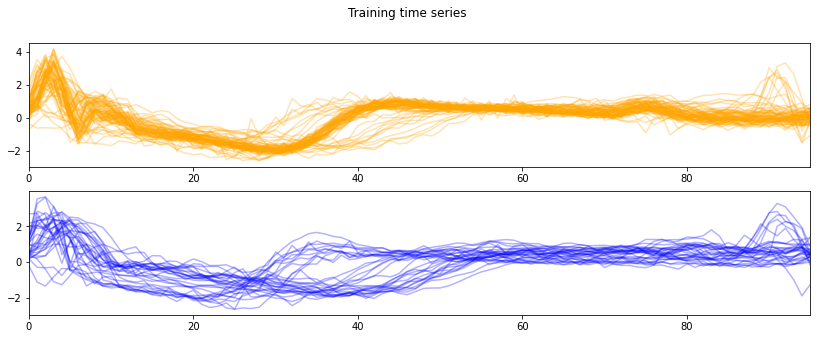

In [20]:
plt.figure(figsize=(14,5))
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    for ts in X_train[y_train == cl]:
        plt.plot(ts.ravel(), color="orange" if cl > 0 else "blue", alpha=.3)
    plt.xlim(0, size - 1)
plt.suptitle("Training time series")
plt.show()

In [22]:
early_clf = NonMyopicEarlyClassifier(n_clusters=3, cost_time_parameter=1e-3,lamb=1e2,random_state=0)

In [23]:
early_clf.fit(X_train, y_train)

NonMyopicEarlyClassifier(base_classifier=None, cost_time_parameter=0.001,
                         lamb=100.0, min_t=1, n_clusters=3, random_state=0)

In [24]:
preds, times = early_clf.predict_class_and_earliness(X_test)

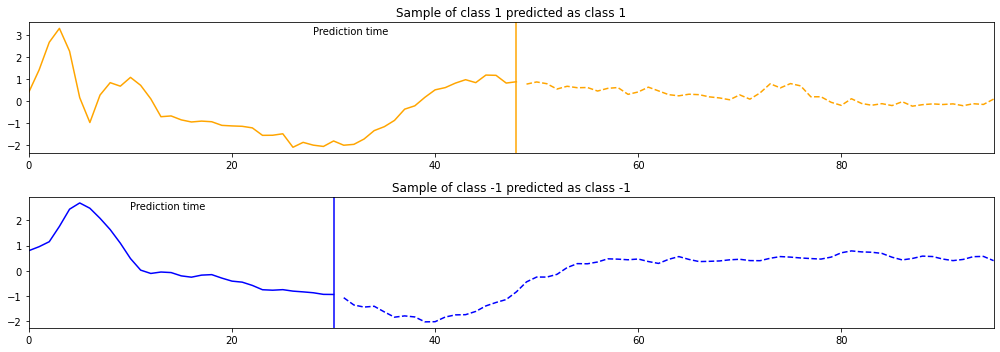

In [26]:
plt.figure(figsize=(14,5))
plt.subplot(2, 1, 1)
ts_idx = 0
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="orange")


plt.subplot(2, 1, 2)
ts_idx = 9
t = times[ts_idx]
plot_partial(X_test[ts_idx], t, y_test[ts_idx], preds[ts_idx], color="blue")
plt.tight_layout()
plt.show()

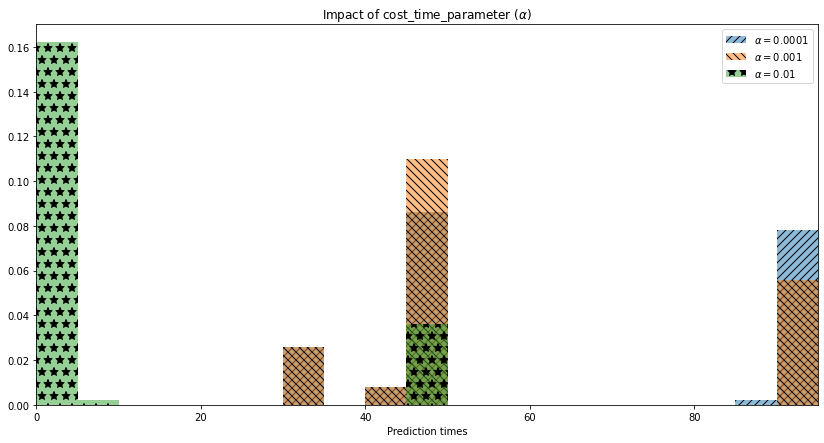

In [28]:
plt.figure(figsize=(14,7))
hatches = ["///", "\\\\\\", "*"]
for i, cost_t in enumerate([1e-4, 1e-3, 1e-2]):
    early_clf.set_params(cost_time_parameter=cost_t)
    early_clf.fit(X_train, y_train)
    preds, times = early_clf.predict_class_and_earliness(X_test)
    plt.hist(times,
             alpha=.5, hatch=hatches[i],
             density=True,
             label="$\\alpha={}$".format(cost_t),
             bins=numpy.arange(0, size, 5))
plt.legend(loc="upper right")
plt.xlim(0, size - 1)
plt.xlabel("Prediction times")
plt.title("Impact of cost_time_parameter ($\\alpha$)")
plt.show()